# Statistical Analysis and Modeling of the Chicago Food Inspections Data
This notebook reads the feature set joined in the `03_join_features_from_data_prep` notebook which contains the food inspections features created in the `01_food_inspections_data_prep` notebook and the census features created in the `02_census_data_prep` notebook and does a descriptive analysis of the types of food establishments that fail inspections at the highest rates.  The notebook then reads the data splits from `04_create_data_splits` to apply a number of models and analyze model performance and feature effect sizes through a series of plots and statistical tests.

See the `01_food_inspections_data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  See the `02_census_data_prep` notebook for the US Census API terms of use.

### Analysis and Models in this Notebook

- Descriptive analysis of types of food establishments that fail inspections at the highest rates
- K Means++ on risk scores to see if data points actually cluster according to these 3 risk groupings
- Comparison of ML models for predicting a failure
- Analysis of predictive variables from Lasso Logistic Regression model

### Set Global Seed

In [1]:
SEED = 666

### Imports

In [2]:
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from pylab import figure

from scipy.stats.stats import ttest_ind, pearsonr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import statsmodels.api as sm

### Read Chicago Food Inspections Feature Dataset from the Data Prep Notebook

In [3]:
feature_df = pd.read_csv('../data/Final_Features.gz', compression='gzip')

### Descriptive Analysis of Failures Rates by Category
- By risk group
- By facility type
- By inspection type
- By zip

In [4]:
def get_failure_rates(feature_df, category):
    """
    Given a dataset of features and a category, assuming that
    the result (target/response) feature is present, compute
    the rate of the positive class, in this context, a failing
    food inspection.
    """
    
    groups_df = (feature_df.groupby([category])[['result']].sum() / 
                 feature_df.groupby([category])[['result']].count()
                ).reset_index()
    
    return Counter(dict(zip(groups_df[category].tolist(), groups_df['result'].tolist())))

In [5]:
def plot_failure_rates(count_dict, category, n=20, x_size=8, y_size=8, color='orange'):
    """
    Given a dictionary of failure rates of type collections.Counter,
    plot the ordered failure rates with the number of items showing,
    plot size, and colors passed as parameters or set to default values.
    """
    
    top_words = OrderedDict(sorted(count_dict.most_common(n), key=lambda x: x[1]))
    
    
    plt.figure(figsize=(x_size, y_size))
    plt.barh(range(len(top_words)), top_words.values(), align='center', color=color)
    plt.yticks(range(len(top_words)), list(top_words.keys()))
    
    plt.title('Failure Rate by Food Establishment: {}'.format(category))
    plt.xlabel('Failure Rate')
    plt.ylabel('Groups')

    plt.show()

### Create Categorical Columns by "Un-One-Hot-Encoding" via the "idxmax" Method

In [6]:
cols = feature_df.columns
feature_df['facility_type'] = feature_df[[col for col in cols if 'facility_type' in col]].idxmax(axis=1)
feature_df['inspection_type'] = feature_df[[col for col in cols if 'inspection_type' in col]].idxmax(axis=1)
feature_df['zip'] = feature_df[[col for col in cols if 'zip' in col]].idxmax(axis=1)

### Create Dictionaries of Failure Rates

In [7]:
risk_dict = get_failure_rates(feature_df, 'risk')
facility_type_dict = get_failure_rates(feature_df, 'facility_type')
inspection_type_dict = get_failure_rates(feature_df, 'inspection_type')
zip_dict = get_failure_rates(feature_df, 'zip')

### Plot Failure Rates by Risk Group

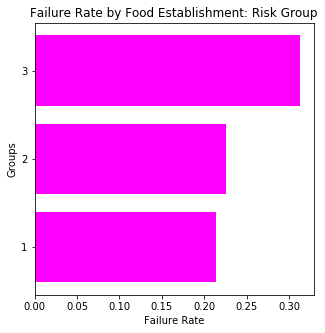

In [8]:
plot_failure_rates(risk_dict, category='Risk Group', n=30, x_size=5, y_size=5, color='magenta')

### Check if there is a Significant Difference in Failure Rates between Groups 1 and 2
Null hypothesis is that there is no difference in failure rate between the two groups.  By convention, we use a significance level of 0.05.  Here we use the Welch Test to avoid assuming constant variance, though we do assume independence of samples, which we would expect, as it seems unlikely that the same establishment was evaluated as being both a 1 and a 2.

In [9]:
t, p = ttest_ind(feature_df['result'][feature_df['risk'] == 1].values,
                 feature_df['result'][feature_df['risk'] == 2].values,
                 equal_var=False)

In [10]:
p

6.077054519260939e-06

### Plot Failure Rates by Facility Type

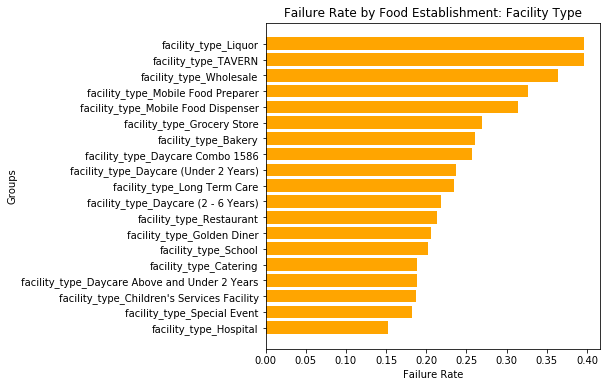

In [11]:
plot_failure_rates(facility_type_dict, category='Facility Type', n=30, x_size=6, y_size=6, color='orange')

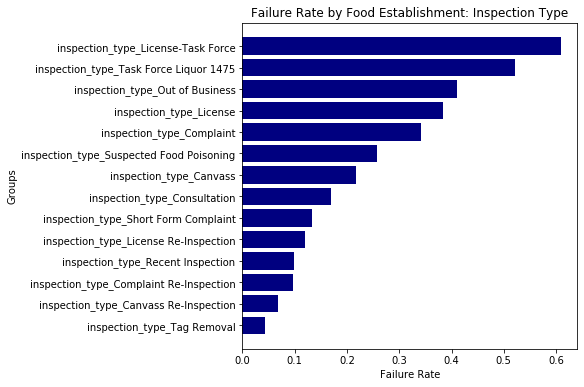

In [12]:
plot_failure_rates(inspection_type_dict, category='Inspection Type', n=30, x_size=6, y_size=6, color='navy')

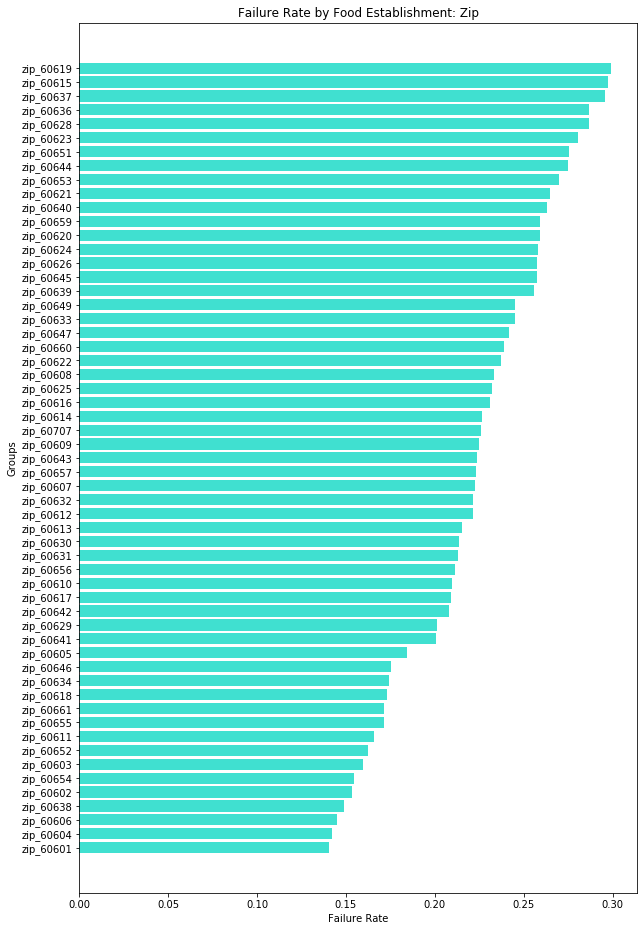

In [13]:
plot_failure_rates(zip_dict, category='Zip', n=100, x_size=10, y_size=16, color='turquoise')

### Examine Median Household Income by Zip Code

In [14]:
zip_income_df = feature_df[['zip', 'median_household_income']].drop_duplicates()\
                                                              .sort_values('median_household_income')

### Plot Median Household Income by Zip Code

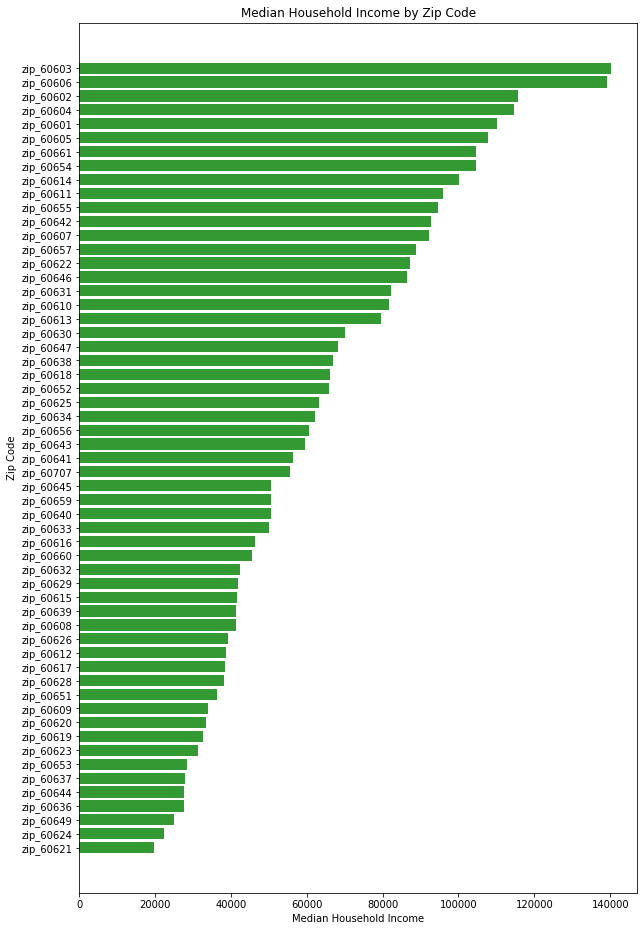

In [15]:
model_range = range(0, len(zip_income_df))

plt.figure(figsize=(10, 16))
plt.barh(model_range, zip_income_df['median_household_income'], color='green', alpha=0.8)
plt.yticks(model_range, zip_income_df['zip'])

plt.ylabel('Zip Code')
plt.xlabel('Median Household Income')
plt.title('Median Household Income by Zip Code')

plt.show()

### Create Bins for Median Household Income

In [16]:
feature_df['median_household_income_bucket'], bins = pd.qcut(feature_df['median_household_income'], 10, retbins=True)

### Plot Failure Rate by Median Household Income Bucket

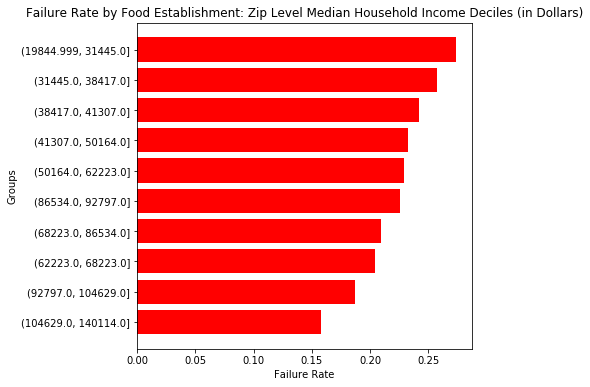

In [17]:
income_buckets_dict = get_failure_rates(feature_df, 'median_household_income_bucket')
plot_failure_rates(income_buckets_dict, category='Zip Level Median Household Income Deciles (in Dollars)',
                   n=30, x_size=6, y_size=6, color='red')

### Drop Extra Columns from Failure Rate Analysis

In [18]:
feature_df = feature_df.drop(['facility_type', 'inspection_type', 'zip', 'median_household_income_bucket'], 1)

### Read Train and Test Splits

In [19]:
X_train = pd.read_csv('../data/X_train.gz', compression='gzip')
X_test = pd.read_csv('../data/X_test.gz', compression='gzip')
y_train = pd.read_csv('../data/y_train.gz', compression='gzip').values.flatten()
y_test = pd.read_csv('../data/y_test.gz', compression='gzip').values.flatten()

### Define Function to Analyze Variance Explained per Number of Principle Components

In [20]:
def plot_pca(X):
    """
    Plots variance explained per number of principle components.
    """
    
    pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
    pca_full.fit(X)

    plt.clf()
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained by Principal Components')
    plt.show()

### Define Function to Plot the Value of the K Means++ Objective Function per Number of Clusters

In [21]:
def plot_kmeans(X, upper=20):
    """
    Plots value of K Means++ objective function per number of clusters.
    """
    
    distorsions = []
    for k in range(1, upper):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=SEED, n_jobs=-1)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)

    plt.plot(range(1, upper), distorsions)
    plt.title('K Means++ Elbow Curve')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Value of Objective Function')
    plt.show()

### Define Function to Plot K Means++ Clusters

In [22]:
def plot_clusters(X, num_clusters):
    """
    Plots datapoints and cluster assignments in 3D space.
    """

    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=SEED, n_jobs=-1)
    kmeans.fit(X)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    print('Centroids: \n')
    print(centroids)
    print()

    color_options = ['g', 'r', 'b', 'y', 'c', 'm', 'b', 'w']
    colors = color_options[0:num_clusters]

    c = Counter(labels)
    fig = figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')

    for i in range(len(X)):
        ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], s=10)

    for cluster in range(0, num_clusters):
        print('Cluster {} contains {} samples'.format(cluster, c[cluster]))
        
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],\
               marker='x', s=100, linewidths=5, zorder=100, c=colors)

    plt.title('Projected K Means++ Clusters', fontsize=20)
    plt.show()
    
    return kmeans

### See if We Can Reproduce Risk Clusters for the Establishments Identified by Three Risk Levels
- Scale the data to make the distance comparisons equal across features.
- **Note:** that we drop the risk groups so that we aren't clustering on the categories we are testing for by clustering the data.

In [23]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
Xt = minmax_scaler.fit_transform(X_train.drop('risk', 1))

### Plot the Variance Explained per Number of Principle Components

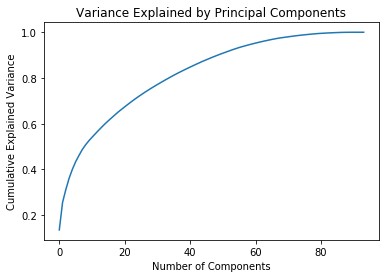

In [24]:
plot_pca(Xt)

### Plot the KMeans Objective Function for a Feature Set of Three Principle Components
It is clear that more components are needed to explain the variance in the dataset, but it's difficult to visualize more than three features in a plot.

In [25]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(Xt)

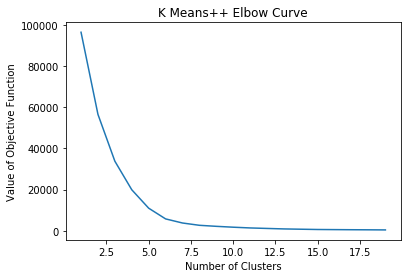

CPU times: user 1.44 s, sys: 527 ms, total: 1.97 s
Wall time: 15.5 s


In [26]:
%%time
plot_kmeans(X_PCA)

### Plot Three Clusters (for the Three Risk Groups We Might Expect) in Three Dimensions (for Easy Inspection)

Centroids: 

[[ 0.42722668  0.6165743   0.01617524]
 [ 0.23511438 -0.58364992  0.03820373]
 [-0.66956937 -0.00277267 -0.05594107]]

Cluster 0 contains 43641 samples
Cluster 1 contains 45894 samples
Cluster 2 contains 43961 samples


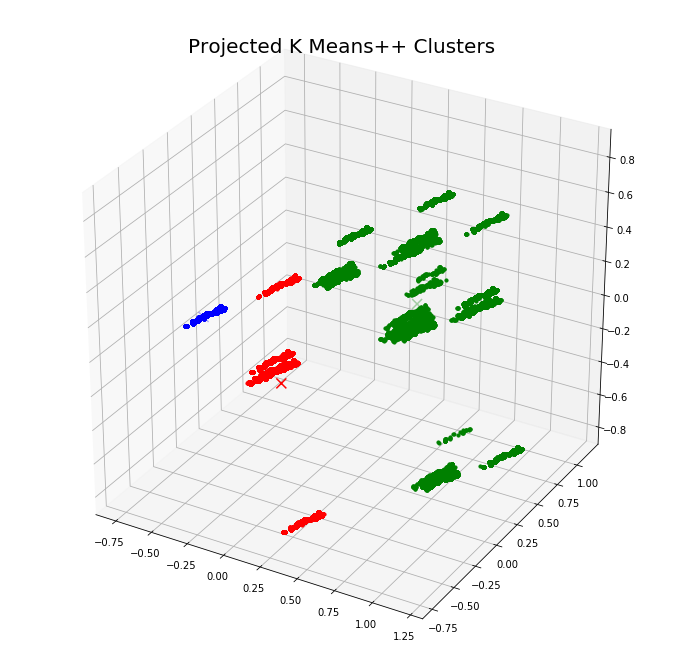

CPU times: user 10min 26s, sys: 7.22 s, total: 10min 33s
Wall time: 10min 35s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=666, tol=0.0001, verbose=0)

In [27]:
%%time
plot_clusters(X_PCA, 3)

### Summary of K Means++ Findings
1. With the small amount of variance explained by three principle components, we are unlikely to have meaningful clusters when projecting them into three dimensions.
2. It's clear by visualizing the clusters in three dimensions that there are more than three distinct clusters.

### View Prevalence of Failing an Inspection to Select a Classification Metric of Interest
Either ROC AUC or PR AUC could be useful metrics for model comparison given the prevalence of the target variable (failing an inspection).  We will preference PR AUC for model comparison with the main interest being to balance
- **Recall:** the number of food establishments that were correctly predicted by the model to fail over the total number of food establishmets that fail.
- **Precision:** the number of food establishments that were correctly predicted by the model to fail over the number of food establishments predicted by the model to fail.

In [28]:
np.mean(y_train)

0.222201414274585

### Define K Fold Cross-Validation Grid with Scaling to Fit Classifiers and Identify Best Hyperparameters
This function is used to select hyperparameters for all models considered and appropriately scales features in-fold and out-of-fold for each of K folds.

- For Logistic Regression, we use 5 folds because the fit time is fast.  
- For KNN, we switch to 3 folds because the fit time is slow.
- For XGBoost, we use the random search option with 5 folds as the parameter space is large and we want to avoid overfitting.

In [29]:
def fit_grid(X_train, y_train, clf, param_grid, n_splits=5, r_search_iters=0, scoring='average_precision'):
    """
    Uses an sklearn pipeline to scale selected columns at each iteration of K Fold CV
    and fits models using the parameters in the grid passed to identify the model
    with the best mean test score based on the scoring metric supplied which
    defaults to 'average_precision'.  Uses random grid search if desired.
    """
    
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    
    pipeline = Pipeline([('scaler', minmax_scaler),
                         ('clf', clf)])
    
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=SEED)
    
    if r_search_iters:
        gs = RandomizedSearchCV(estimator=pipeline,
                                param_distributions=param_grid,
                                scoring=scoring,
                                cv=cv,
                                n_iter=r_search_iters,
                                refit=True,
                                n_jobs=-1,
                                random_state=SEED,
                                verbose=2)
    else:
        gs = GridSearchCV(estimator=pipeline,
                          cv=cv,
                          param_grid=param_grid,
                          scoring=scoring,
                          n_jobs=-1,
                          refit=True,
                          verbose=2)
    
    gs.fit(X_train, y_train)
    
    scores = gs.cv_results_['mean_test_score']
    best_score = round(gs.best_score_, 5)
    best_params = gs.best_params_
    best_clf = gs.best_estimator_
    
    print("Best score: {}".format(best_score))
    print("Best parameters: {}".format(best_params))
    
    return best_clf

### Define Lasso Logistic Regression Model

In [30]:
clf = LogisticRegression(penalty='l1',
                         solver='liblinear',
                         fit_intercept=True,
                         max_iter=1000)

### Define Lasso Hyperparameter Space

In [31]:
param_grid = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

### Fit Lasso Model with Grid Search

In [32]:
%%time
lasso_clf = fit_grid(X_train, y_train, clf, param_grid, n_splits=5)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best score: 0.37172
Best parameters: {'clf__C': 1}
CPU times: user 13 s, sys: 589 ms, total: 13.6 s
Wall time: 1min 37s


### Define K Nearest Neighbors Model

In [33]:
clf = KNeighborsClassifier()

### Define KNN Hyperparameter Space

In [34]:
param_grid = {'clf__n_neighbors': [7, 15, 25]}

### Fit KNN Model with Grid Search

In [35]:
%%time
knn_clf = fit_grid(X_train, y_train, clf, param_grid, n_splits=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 15.3min remaining: 19.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 20.8min finished


Best score: 0.34487
Best parameters: {'clf__n_neighbors': 25}
CPU times: user 36.1 s, sys: 369 ms, total: 36.5 s
Wall time: 21min 21s


### Define XGBoost Model

In [36]:
clf = xgb.XGBClassifier(objective='binary:logistic',
                        tree_method='hist',
                        predictor='cpu_predictor')

### Define XGBoost Hyperparameter Space

In [37]:
param_grid = {'clf__n_estimators': [100, 200, 400, 600],
              'clf__learning_rate': [0.05, 0.1, 0.2],
              'clf__max_depth': [3, 4, 5, 6, 7],
              'clf__subsample': [0.3, 0.5, 0.7],
              'clf__colsample_bytree': [0.3, 0.5, 0.7],
              'clf__min_child_weight': [3, 5, 7]}

### Fit XGBoost Model with Random Grid Search
This is potentially overkill for this problem, but we use 5 folds and 50 iterations of random search to achieve a stable estimate of the best hyperparameters.  Fitting this model provides a good sense for the upper limit of predictive accuracy possible on this dataset, though there may be deep learning architectures that could push performance further.  My main interest for this analysis is an understanding of features associated with failing an inspection, and we end up going with the Lasso Logistic Regression model for this reason, as described further down in the notebook.

In [38]:
%%time
xgb_clf = fit_grid(X_train, y_train, clf, param_grid, n_splits=5, r_search_iters=50)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.5min finished


Best score: 0.39191
Best parameters: {'clf__subsample': 0.5, 'clf__n_estimators': 400, 'clf__min_child_weight': 3, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}
CPU times: user 30.3 s, sys: 959 ms, total: 31.3 s
Wall time: 15min 58s


### Evaluate Classifiers on Test Set

In [39]:
def plot_hist(labels, scores, bins=30):
    """
    Plot two histograms: one of
    the actual binary labels
    and one of the model scores
    """
    
    plt.clf()
    plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    sns.distplot(labels, kde=False, color='orange')
    plt.xlabel('Actual Label')
    plt.xticks([0, 1])
    plt.subplot(222)
    sns.distplot(scores, bins=bins, kde=False, color='orange')
    plt.xlabel('Scores')
    plt.xticks([0, 0.25, 0.5, 0.75, 1])
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(223)
    sns.distplot(scores[labels == 0], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 0')
    plt.subplot(224)
    sns.distplot(scores[labels == 1], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 1')
    plt.suptitle('Histograms of Model Scores by Actual Label')
    plt.show()

In [40]:
def plot_roc(labels, scores):
    """
    Plots the true positive rate vs. the false positive rate
    """

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.clf()
    plt.plot(fpr, tpr, color='darkgreen', lw=2,
             label='AUC = %0.3f' % (roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.suptitle('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.show()

In [41]:
def plot_pr_by_threshold(labels, scores):
    """
    Plots model precision and recall
    by threshold, using matplotlib and seaborn
    allowing a user to visualize model performance
    at various thresholds
    """
    
    auc = round(average_precision_score(y_true=labels, y_score=scores), 3)
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    thresholds = np.append(thresholds, 1)

    plt.clf()
    plt.plot(thresholds, precision, color=sns.color_palette()[0])
    plt.plot(thresholds, recall, color=sns.color_palette()[1])

    leg = plt.legend(('Precision', 'Recall'), frameon=True)
    leg.get_frame().set_edgecolor('k')

    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.suptitle('Precision and Recall by Model Threshold - AUC: {}'.format(auc))

    plt.show()

### View Lasso Model Performance

In [42]:
y_prob = lasso_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

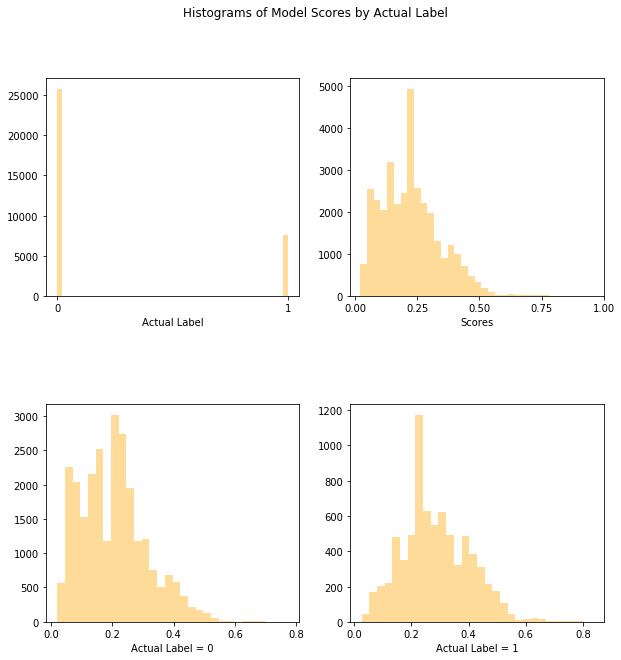

In [43]:
plot_hist(y_test, y_prob)

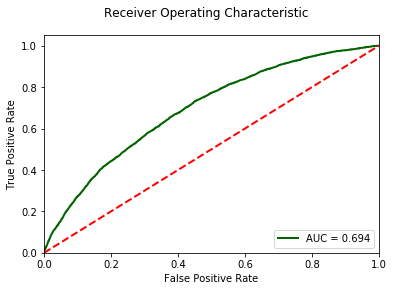

In [44]:
plot_roc(y_test, y_prob)

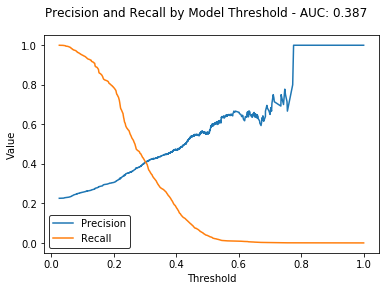

In [45]:
plot_pr_by_threshold(y_test, y_prob)

### View KNN Model Performance

In [46]:
y_prob = knn_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

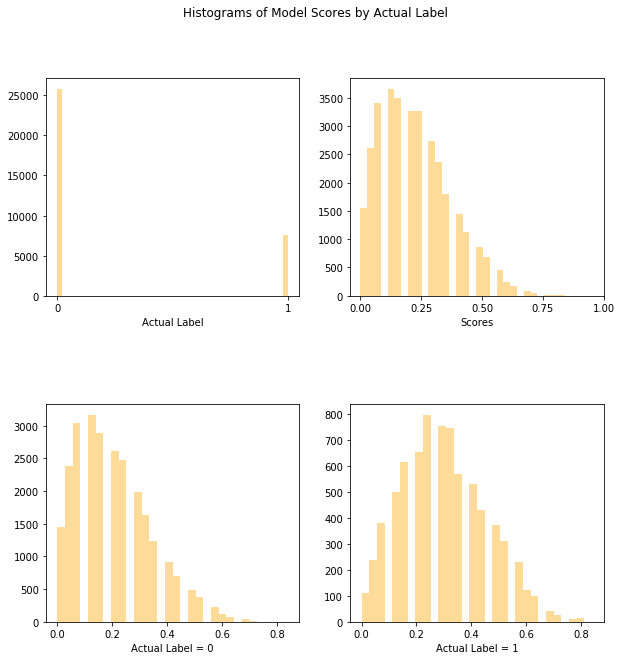

In [47]:
plot_hist(y_test, y_prob)

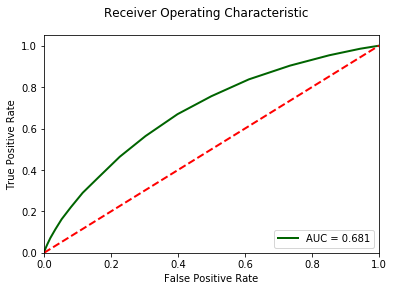

In [48]:
plot_roc(y_test, y_prob)

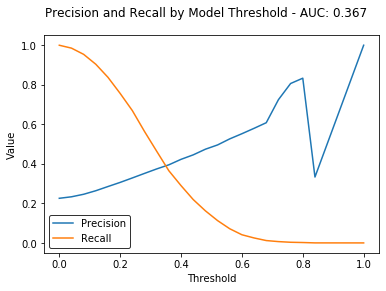

In [49]:
plot_pr_by_threshold(y_test, y_prob)

### View XGBoost Model Performance

In [50]:
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

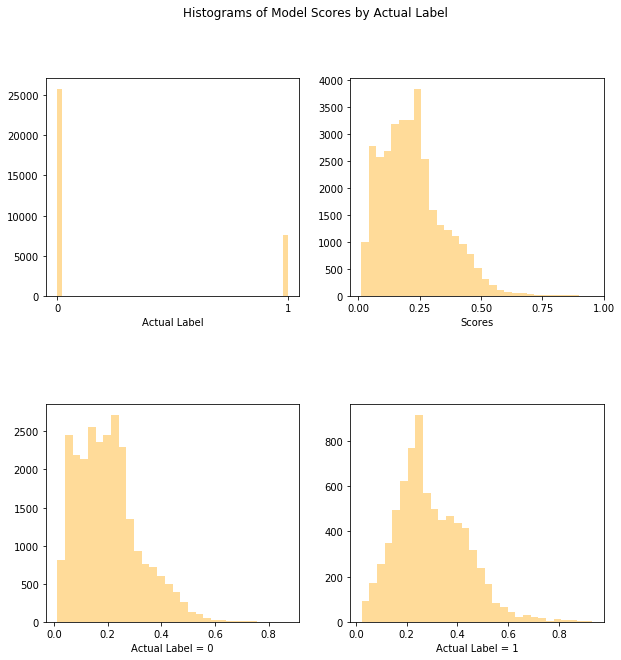

In [51]:
plot_hist(y_test, y_prob)

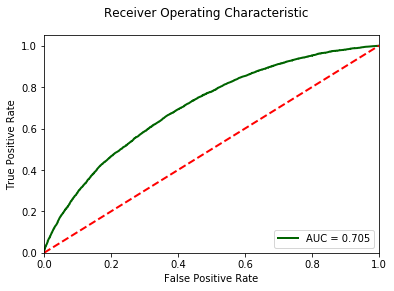

In [52]:
plot_roc(y_test, y_prob)

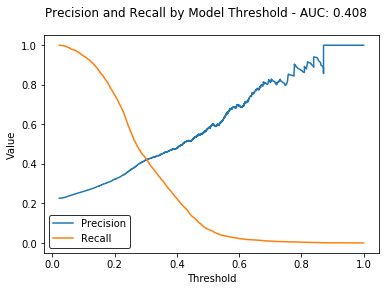

In [53]:
plot_pr_by_threshold(y_test, y_prob)

### Model Summary
Fitting all three models is informative because it demonstrates how effective we might reasonably expect an ML model to be at classifying food establishments as expected to fail or pass an inspection.  That said, we see that no model achieves particularly high AUC, and that we are forced to have either low recall or low precision when choosing a threshold for model scores.  Because the Lasso model is about as performant as the XGBoost model with fewer parameters to tune, there is good reason to prefer the Lasso model for its interpretability.

### Interpreting Features
For the purpose of this analysis, we are particularly concerned with understanding the factors associated with passing or failing an inspection, and the Lasso Logistic Regression model provides a nice way to understand these factors by examining the odds of passing or failing an inspection per unit change in each individual predictor, controlling for all other features in the model.  Because all predictors are either binary or on the scale of 0 to 1, we can interpret the bars for each feature as:
- The odds of failure if the feature is present vs absent for binary features.
- The odds of failure if the feature achieves its max vs min value for continuous features with in between values corresponding to less severe changes in the odds of the response.

In [54]:
def plot_coef_effect_size(clf, features, zero_threshold=0.01, x_size=12, y_size=12):
    """
    Plots the change in the odds of the response per unit change 
    in the predictor for each feature given a logistic
    regression model and array of features.  Uses the zero 
    threshold to only plot features with coefficient value
    greater than the threshold.
    """

    features_and_intercept = np.concatenate((features, ['intercept']), 0)
    coefficients = np.concatenate((clf.coef_[0], clf.intercept_), 0)

    coefficients[np.abs(coefficients) < zero_threshold] = 0
    coefficients = np.exp(coefficients)

    idx1 = coefficients.argsort()
    all_effects = coefficients[idx1]

    idx2 = np.nonzero(all_effects-1.0)
    effects = all_effects[idx2]
    labels = features_and_intercept[idx1][idx2]
    
    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title('Exponentiated Logistic Regression Coefficients')
    plt.barh(range(len(effects)), effects, color='navy', align='center')
    plt.axvline(x=1, color='red', linestyle='--')
    plt.yticks(range(len(effects)), labels)
    plt.xlabel('Change in Odds of Response per Unit Change in Predictor')
    plt.ylabel('Feature')
    
    plt.legend(['No Change', 'Change in Odds of Response per Unit Change in Predictor'])

    plt.show()

### Plot the Effect Sizes for Features for which the Raw Coefficient is < -0.5 or > 0.5
The effect sizes are the exponentiated coefficients which detail the change in the odds of the response per unit change in the predictor.

<Figure size 432x288 with 0 Axes>

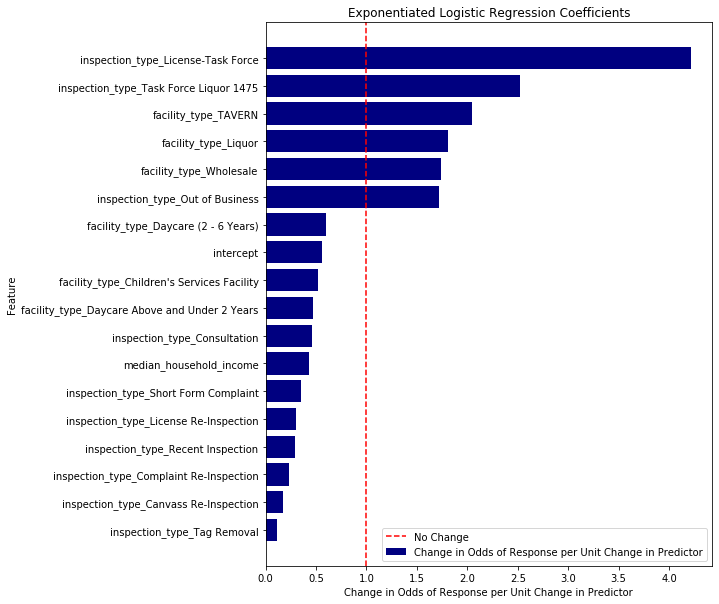

In [55]:
plot_coef_effect_size(lasso_clf['clf'], X_train.columns, zero_threshold=0.5, x_size=8, y_size=10)

### Refit Lasso without Median Household Income

In [56]:
clf = LogisticRegression(penalty='l1',
                         solver='liblinear',
                         fit_intercept=True,
                         max_iter=1000)

In [57]:
param_grid = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [58]:
%%time
no_income_lasso_clf = fit_grid(X_train.drop('median_household_income', 1), y_train, clf, param_grid, n_splits=5)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.0min finished


Best score: 0.37175
Best parameters: {'clf__C': 1}
CPU times: user 3.59 s, sys: 524 ms, total: 4.12 s
Wall time: 2min 4s


### Plot Lasso Coefficients without Median Household Income for which the Raw Coefficient is < -0.5 or > 0.5
Note that when we don't control for median household income, the top predictors are very different, many ostensibly absorbing the confounding effects of the economic status of each neighborhood.

<Figure size 432x288 with 0 Axes>

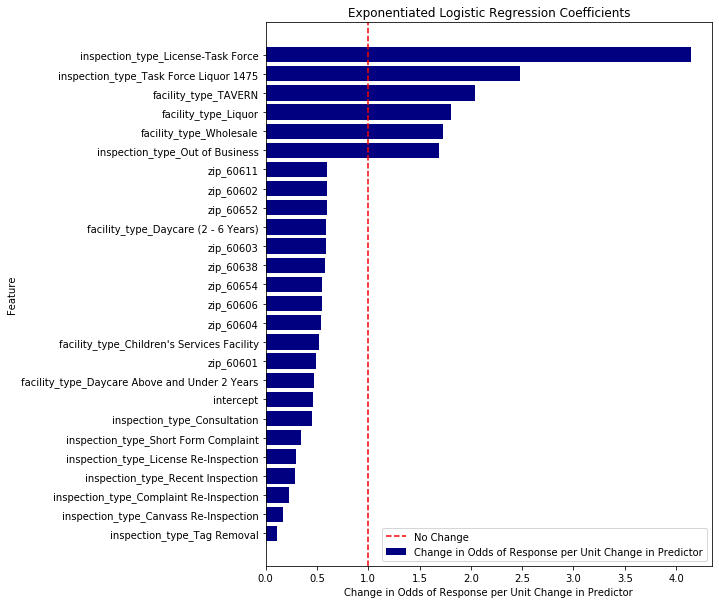

In [59]:
plot_coef_effect_size(no_income_lasso_clf['clf'], X_train.drop('median_household_income', 1).columns,
                      zero_threshold=0.5, x_size=8, y_size=10)

### Check the Relationship Between Failure Rate and Income

<Figure size 432x288 with 0 Axes>

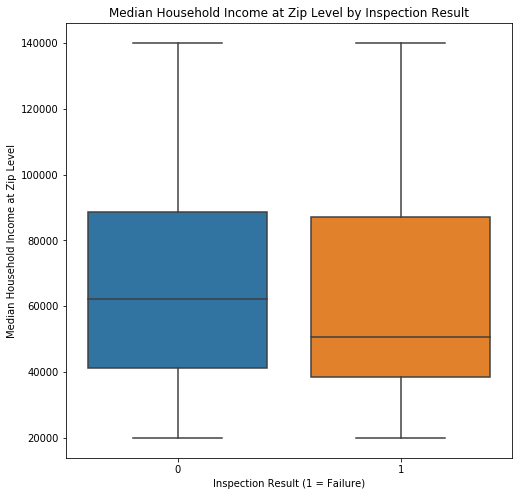

In [60]:
plt.clf()
plt.figure(figsize=(8, 8))
sns.boxplot(x='result', y='median_household_income', data=feature_df)
plt.title('Median Household Income at Zip Level by Inspection Result')
plt.ylabel('Median Household Income at Zip Level')
plt.xlabel('Inspection Result (1 = Failure)')
plt.show()

### Test Null Hypothesis of No Correlation
Pearson tends to be used for modeling linear relationships between continuous features and assumes constant variance (homoscedasticity).  By convention, we use a significance level of 0.05.

In [61]:
stat, p = pearsonr(X_train['median_household_income'], y_train)

In [62]:
p

6.637679598727949e-142

### Use Logistic Regression to Test Null Hypothesis of No Relationshiop
**Note:** Logistic Regression avoids the assumption of homoscedasticity which is an assumption of the pearson correlation test.  Here we use the stats model API to retrieve test statistics and p values for coefficients.

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
fts = ['median_household_income']
Xt = scaler.fit_transform(X_train[fts].values)
Xt = pd.DataFrame(Xt, columns=fts)
Xt['intercept'] = 1

model = sm.Logit(y_train, Xt)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.527228
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               133496
Model:                          Logit   Df Residuals:                   133494
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                0.004629
Time:                        18:49:03   Log-Likelihood:                -70383.
converged:                       True   LL-Null:                       -70710.
Covariance Type:            nonrobust   LLR p-value:                2.162e-144
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
median_household_income    -0.7152      0.028    -25.263      0.000      -0.771      -0.660
intercept                  -0.9955      0.012    -83.865      0.000      -1.019      -0.972
===========================================================================================
"""

### Check Effect Sizes and Significance of Top Predictors from Lasso
Here we use a **threshold of raw coefficient < -0.5 or > 0.5**.  This threshold could be tuned to include more features, but by setting this somewhat aggressively, we focus on top contributors to the model.

In [64]:
features_weights = list(zip(X_train.columns, lasso_clf['clf'].coef_[0]))
features_weights_sorted_filtered = sorted([pair for pair in features_weights if abs(pair[1]) > 0.5],
                                          key=lambda pair: pair[1], reverse=True)
reduced_features = [pair[0] for pair in features_weights_sorted_filtered]

In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xt = scaler.fit_transform(X_train[reduced_features].values)
Xt = pd.DataFrame(Xt, columns=reduced_features)
Xt['intercept'] = 1

model = sm.Logit(y_train, Xt)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.503424
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               133496
Model:                          Logit   Df Residuals:                   133478
Method:                           MLE   Df Model:                           17
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                 0.04957
Time:                        18:49:03   Log-Likelihood:                -67205.
converged:                       True   LL-Null:                       -70710.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
inspection_type_License-Task Force                1.5060      0.096     15.746      0.000       1.319       1.693
inspection_type_Task Force Liquor 1475            1.0637      0.142      7.515      0.000       0.786       1.341
facility_type_TAVERN                              0.9738      0.159      6.144      0.000       0.663       1.284
facility_type_Liquor                              0.8620      0.087      9.862      0.000       0.691       1.033
facility_type_Wholesale                           0.6501      0.109      5.952      0.000       0.436       0.864
inspection_type_Out of Business                   0.6292      0.142      4.423      0.000       0.350       0.908
facility_type_Daycare (2 - 6 Years)              -0.2161      0.057     -3.774      0.000      -0.328      -0.104
facility_type_Children's Services Facility       -0.3792      0.054     -6.958      0.000      -0.486      -0.272
facility_type_Daycare Above and Under 2 Years    -0.4502      0.062     -7.217      0.000      -0.572      -0.328
inspection_type_Consultation                     -0.6554      0.118     -5.534      0.000      -0.888      -0.423
median_household_income                          -0.9203      0.029    -31.413      0.000      -0.978      -0.863
inspection_type_Short Form Complaint             -0.9168      0.041    -22.358      0.000      -0.997      -0.836
inspection_type_License Re-Inspection            -1.0653      0.038    -27.973      0.000      -1.140      -0.991
inspection_type_Recent Inspection                -1.1441      0.212     -5.406      0.000      -1.559      -0.729
inspection_type_Complaint Re-Inspection          -1.2939      0.045    -29.032      0.000      -1.381      -1.207
inspection_type_Canvass Re-Inspection            -1.6203      0.032    -50.062      0.000      -1.684      -1.557
inspection_type_Tag Removal                      -2.0651      0.229     -9.022      0.000      -2.514      -1.617
intercept                                        -0.6684      0.013    -51.540      0.000      -0.694      -0.643
=================================================================================================================
"""

### Check Performance of the Reduced Model Using Logistic Regression with No Regularization
Setting the regularization parameter to `1e8` we get effectively no regularization, as in the statsmodel API Logit model.  See this issue for details: https://github.com/scikit-learn/scikit-learn/issues/6738

In [66]:
reduced_clf = LogisticRegression(C=1e8, # https://github.com/scikit-learn/scikit-learn/issues/6738
                                 penalty='l2',
                                 solver='liblinear',
                                 fit_intercept=True,
                                 max_iter=1000)

In [67]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train[reduced_features].values)
X_test_scaled = minmax_scaler.transform(X_test[reduced_features].values)

In [68]:
%%time
reduced_clf.fit(X_train_scaled, y_train)

CPU times: user 865 ms, sys: 12.8 ms, total: 878 ms
Wall time: 358 ms


LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### View Performance Plots

In [69]:
y_prob = reduced_clf.predict_proba(X_test_scaled)[:, 1]

<Figure size 432x288 with 0 Axes>

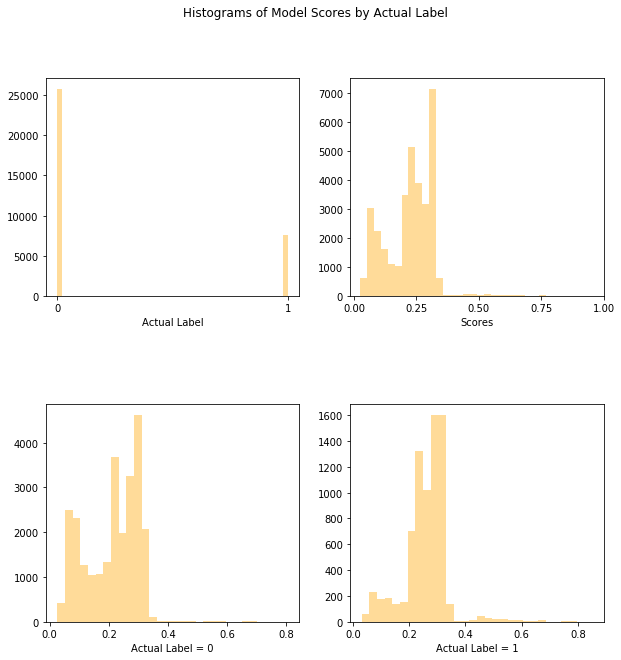

In [70]:
plot_hist(y_test, y_prob)

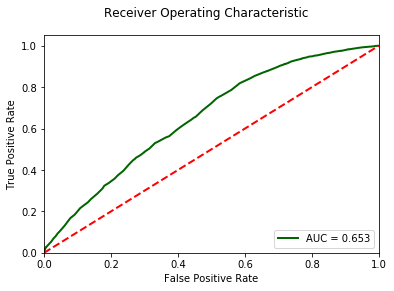

In [71]:
plot_roc(y_test, y_prob)

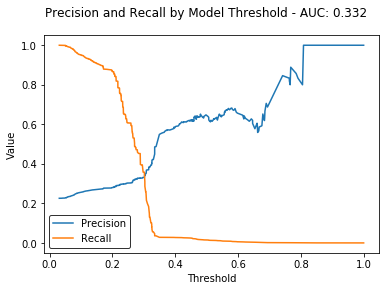

In [72]:
plot_pr_by_threshold(y_test, y_prob)

### Plot Effect Sizes from the Reduced Model
The same features are displayed due to the raw coefficient threshold of < -0.5 or > 0.5 for selecting the reduced feature set, but with the less important features absent, the more important predictors take on different values.

<Figure size 432x288 with 0 Axes>

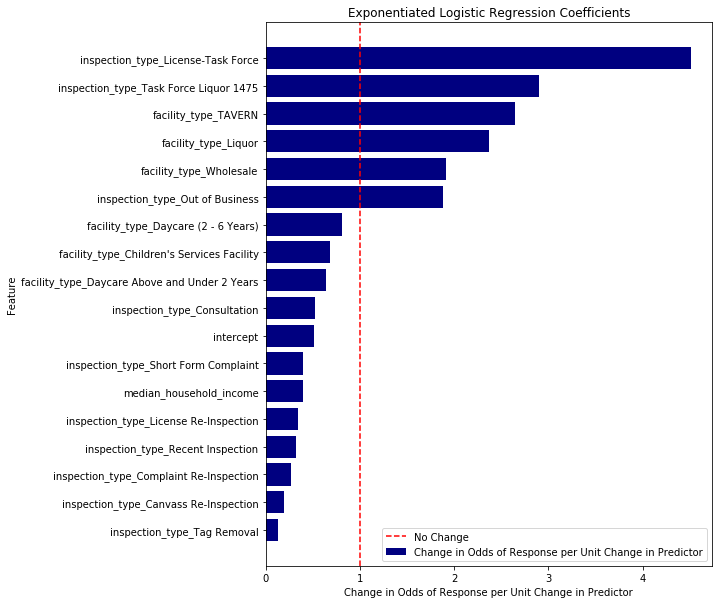

In [73]:
plot_coef_effect_size(reduced_clf, reduced_features, zero_threshold=0, x_size=8, y_size=10)